# Chest Ct Scans Notebook 2 

#### MGTA 611: Wasif Mukadam 

## Contents

1. Introduction 
2. Data Pre-Processing
3. CNN Model 1 using Dropout layers and l2 regularizers
4. CNN Model 2 using more dropout layers and deeper architecture
5. Augmentation of the Data
6. CNN Model 3 post Augmentation 1 
7. CNN Model 4 post Augmentation 2 using reduced filter units
8. Test the model by feeding a single image
9. Conclusion 

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import models, layers, optimizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import itertools
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
np.random.seed(123)

### 1. Introduction

This Jupyter Notebook is dedicated to developing a deep learning model using Convolutional Neural Networks (CNNs) to detect and classify various types of lung cancer through chest CT scans. The dataset selected for this task is comprised of a diverse range of cancer cell types, including Adenocarcinoma, Large cell carcinoma, and Squamous cell carcinoma, in addition to a separate folder for normal cells. The dataset is pre-divided into training, testing, and validation sets, which will facilitate the creation of an efficient and accurate model.

Lung cancer is a leading cause of cancer-related fatalities worldwide, and early detection and treatment are critical ("Lung Cancer Statistics | How Common Is Lung Cancer"). The business problem that this project aims to address is the necessity for an efficient and accurate model to detect lung cancer. Our proposal is to leverage deep learning techniques using chest CT scans to detect and classify different types of lung cancer with precision.

The technical problem being tackled involves using Python's deep learning models to accurately detect and classify the presence of different types of cancer. The existing diagnostic methods result in a high misdiagnosis rate and are generally unreliable (Ciello et al.). With deep learning and AI techniques in Python, we aspire to train and optimize a model that can assist radiographers in making precise judgments regarding patients' illnesses. The large dataset size will enable the model to manage the intricacies of the CT scans and adapt to new unseen data.

### 2. Data Pre-Processing

The data preparation phase involved defining three paths for the dataset, namely the train, valid, and test phases. The train_path, valid_path, and test_path were defined to enable easy access to the three sets of data used to evaluate the models' performances. The training dataset is stored in the train_path directory and is used to train the model. Similarly, the validation dataset is stored in the valid_path directory and is used to validate the model's performance during training. Lastly, the test dataset is stored in the test_path directory and is used to evaluate the final performance of the model. By defining these paths, the code enables easy access to the datasets throughout the project.

In [3]:
train_path = "Data/train"
valid_path = "Data/valid"
test_path = "Data/test"

The code below sets the image shape, number of classes and the batch sizes for the deep learning model. The `image_shape` was set to (305,430,1) which defines the shape of the images in the dataset. The first two values represent the height and width of the image respectively, while the final value "1" represented the number of channels for a black and white image. `N_CLASSES` was set to 4 , indicating the number of classes within the dataset. `BATCH_SIZE` was set to 32 which defined the number of images within each batch during training.

The code uses three `ImageDataGenerator` classes from keras library to preprocess the images for training validation and testing. The generators contain parameters for normalization and pixel scaling, directories containing datasets, batch size, target size, color mode, and class mode. The target size parameter specifies the input image size after preprocessing, and color mode converts the images to grayscale format. The class mode parameter is set to 'categorical' to indicate the multiple classes to be predicted by the model. By defining these generators, the code enables efficient image preprocessing and augmentation for model training, validation, and testing.

In [4]:
image_shape = (305,430,1)
N_CLASSES = 4
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(dtype='float32', rescale= 1/255)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   color_mode = "grayscale",
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1/255)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   color_mode = "grayscale",
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1/255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   color_mode = "grayscale",
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


The code below utilizes the next() method on the train_generator, valid_generator, and test_generator to generate a batch of training, validation, and test data, respectively. The resulting T_train, t_train, T_valid, t_valid, T_test, and t_test variables hold the batch of training samples, training labels, validation samples, validation labels, test samples, and test labels, respectively. The dimensions of each of these arrays are printed to the console using the shape attribute. The output shows that the training, validation set, and test set each contain 32 images, each of size 305x430x1, with 4 classes represented by the labels.

In [5]:
T_train, t_train = train_generator.next() #`.next()` at the end of the generator code is used to obtain the next batch of data returning a tuple of samples and labels. 
print("Shape of training samples: ", T_train.shape)
print("Shape of training labels: ", t_train.shape)

T_valid, t_valid = valid_generator.next()
print("Shape of validation samples: ", T_valid.shape)
print("Shape of validation labels: ", t_valid.shape)

T_test, t_test = test_generator.next()
print("Shape of test samples: ", T_test.shape)
print("Shape of test labels: ", t_test.shape)

Shape of training samples:  (32, 305, 430, 1)
Shape of training labels:  (32, 4)
Shape of validation samples:  (32, 305, 430, 1)
Shape of validation labels:  (32, 4)
Shape of test samples:  (32, 305, 430, 1)
Shape of test labels:  (32, 4)


This code segment imports the necessary libraries and defines a list of class names using the `train_generator.class_indices.keys()` method. It then adjusts the batch size of the `test_generator` to `BATCH_SIZE` before creating a figure object and a 3x5 subplot grid. The `test_generator` is then used to obtain a batch of images and labels, and the `imshow()` method from `matplotlib.pyplot` is used to display 10 images from the batch with their respective class names as titles. The `np.argmax()` function is used to obtain the index of the maximum value in the label array, which corresponds to the predicted class of the image. The `xticks` and `yticks` are set to empty lists to remove the axes ticks from the plot.

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


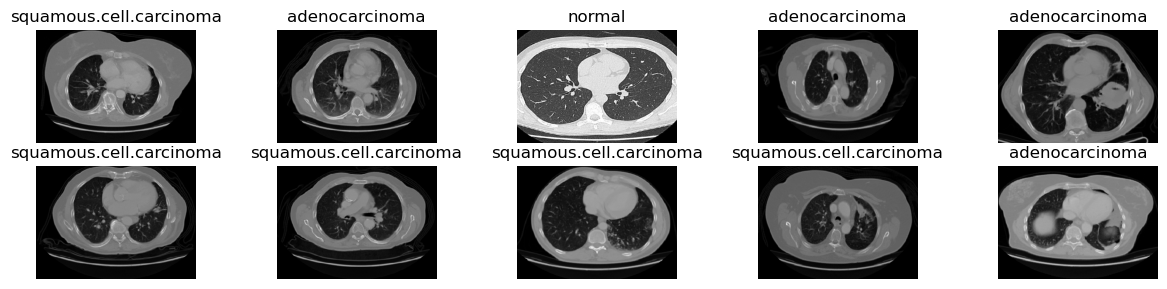

In [6]:
class_names=list(train_generator.class_indices.keys())
print(class_names)

#adjust the batch size 
test_generator.batch_size = BATCH_SIZE

fig = plt.figure(figsize=(15,5))

image_batch,label_batch = test_generator[0]
for i in range(10):
    ax = fig.add_subplot(3,5,i+1,xticks = [], yticks = [])
    ax.imshow(image_batch[i], cmap='gray')
    plt.axis('off')
    plt.title(class_names[np.argmax(label_batch[i])])

### 3. CNN Model 1 using Dropout layers and l2 regularizers

The above code defines a convolutional neural network (CNN) model using the Keras Sequential API. The model consists of several layers, starting with a Conv2D layer that applies 64 filters with a 3x3 kernel and a ReLU activation function to the input image, with zero-padding to ensure the output size is the same as the input size. This is followed by a MaxPooling2D layer that downsamples the feature maps by taking the maximum value within a 2x2 window. The process is repeated with two more Conv2D and MaxPooling2D layers, but with increased filter size of 128 and 256 respectively. The output is then flattened and fed into a fully connected layer with 256 nodes and a ReLU activation function, followed by a Dropout layer that randomly drops out 50% of the nodes to prevent overfitting. Another fully connected layer with 4 nodes and a softmax activation function is added to produce the output probabilities for the 4 classes. L2 regularization with a weight of 0.001 is applied to the convolutional and dense layers to prevent overfitting. The model summary shows the architecture of the model, including the number of parameters in each layer.

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(305,430, 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

2023-03-23 13:39:52.592374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 305, 430, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 215, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 215, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 76, 107, 128)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 107, 256)      295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 38, 53, 256)      0

Several callbacks and optimizer are defined for the model training in the code below. The `ModelCheckpoint` callback is used to save the best weights of the model during training, based on the validation loss. The `EarlyStopping` callback is used to stop the training early if the validation loss does not improve for a certain number of epochs, specified by the `patience` parameter. The `Adam` optimizer is used with a learning rate of 0.001 and decay of 1e-5. The model is compiled with categorical cross-entropy loss and accuracy metrics. The `fit` method is then called on the model, with the training and validation data generators, and the specified callbacks. The `steps_per_epoch` parameter specifies the number of batches to yield from the generator before declaring one epoch finished. The `epochs` parameter specifies the number of epochs to train the model for. The `verbose` parameter is set to 1 to display progress bars during training. The `history` variable stores the training history, including the loss and accuracy metrics for each epoch.

NOTE:
The step of defining a deep learning model, compiling it with appropriate loss function, optimizer and metrics, and training it using the fit method with appropriate parameters is conducted four times in the entire notebook for different parameters.

In [9]:
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
optimizer = optimizers.Adam(learning_rate= 0.001, decay= 1e-5)

model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.7896 - acc: 0.4029
Epoch 1: val_loss improved from inf to 2.41390, saving model to chestmodel.hdf5
20/20 [==============================] - 132s 7s/step - loss: 2.7896 - acc: 0.4029 - val_loss: 2.4139 - val_acc: 0.5000
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 2.1362 - acc: 0.6900
Epoch 2: val_loss did not improve from 2.41390
20/20 [==============================] - 130s 6s/step - loss: 2.1362 - acc: 0.6900 - val_loss: 2.5453 - val_acc: 0.4722
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.6449 - acc: 0.7830
Epoch 3: val_loss improved from 2.41390 to 1.69556, saving model to chestmodel.hdf5
20/20 [==============================] - 130s 7s/step - loss: 1.6449 - acc: 0.7830 - val_loss: 1.6956 - val_acc: 0.6667
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 1.3656 - acc: 0.8385
Epoch 4: val_loss improved from 1.69556 to 1.64063, saving model to c

Epoch 31/100
20/20 [==============================] - ETA: 0s - loss: 0.5011 - acc: 0.9853
Epoch 31: val_loss did not improve from 1.05532
20/20 [==============================] - 130s 7s/step - loss: 0.5011 - acc: 0.9853 - val_loss: 1.2588 - val_acc: 0.7500
Epoch 32/100
20/20 [==============================] - ETA: 0s - loss: 0.5071 - acc: 0.9853
Epoch 32: val_loss did not improve from 1.05532
20/20 [==============================] - 135s 7s/step - loss: 0.5071 - acc: 0.9853 - val_loss: 1.2548 - val_acc: 0.7917
Epoch 33/100
20/20 [==============================] - ETA: 0s - loss: 0.5332 - acc: 0.9869
Epoch 33: val_loss did not improve from 1.05532
20/20 [==============================] - 130s 6s/step - loss: 0.5332 - acc: 0.9869 - val_loss: 1.0702 - val_acc: 0.8333
Epoch 34/100
20/20 [==============================] - ETA: 0s - loss: 0.5188 - acc: 0.9886
Epoch 34: val_loss did not improve from 1.05532
20/20 [==============================] - 129s 6s/step - loss: 0.5188 - acc: 0.9886 -

The code below defines a function `plot_history` that takes the history of a model's training as input and plots the training and validation accuracy and loss over epochs.

In [10]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


The `plot_history()` function below generates two graphs of "Training and Validation accuracy" and "Training and validation loss". The accuracy graph shows that the training accuracy increases rapidly to 94% within the first 10-15 epochs, followed by a plateau between an accuracy of 95-99%. The validation accuracy follows a similar trend, although with more fluctuations and a minimum point between 2-4 epochs.

It's important to note that overfitting is a common problem when dealing with small datasets, and regularization techniques like dropout and weight decay can be helpful in preventing it. However, in some cases, these techniques may not be sufficient to completely eliminate overfitting. In the case of the model I developed, despite using dropout and weight decay, the model still exhibited overfitting.

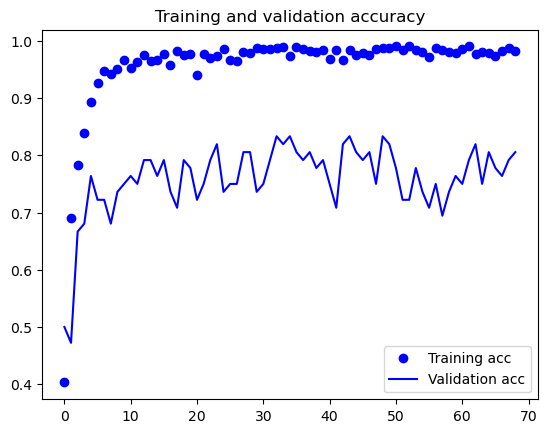

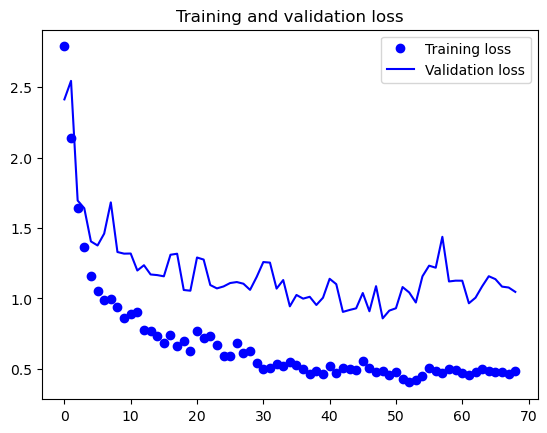

In [11]:
plot_history(history)

The code below loads the saved trained model chestmodel.hdf5 using `models.load_model()` and applies it to the `test_generator` data using `model.predict()`, generating predictions for each image in the test set.

In [12]:
a=models.load_model('chestmodel.hdf5')
test=a.predict(test_generator)

10/10 [==============================] - 20s 2s/step


This code defines a function called `plot_confusion_matrix` that takes a confusion matrix `cm` and a list of `classes` as input and produces a visual representation of the matrix using a blue color map. The `normalize` parameter allows for normalization of the matrix if set to True. The function then sets up the plot, including the title, color bar, and tick marks, and uses the `text` function to display the matrix values in each cell of the plot. The code then generates predictions on a test dataset using a previously loaded model and calculates the confusion matrix. Finally, the function is called with the confusion matrix and a list of class labels, and the resulting plot is displayed.

1/1 [==============================] - 2s 2s/step


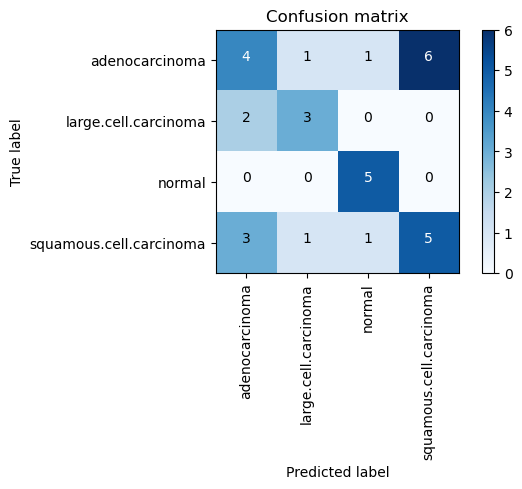

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.xticks(rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    decoy = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > decoy else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Predicting the values from the test dataset
Y_preda = a.predict(T_test)
#Converting predictions classes to one hot vectors 
Y_preda_classes = np.argmax(Y_preda,axis = 1) 
#Converting test observations to one hot vectors
Y_truea = np.argmax(t_test,axis = 1) 
#Computing the confusion matrix
confusion_mtxa = confusion_matrix(Y_truea, Y_preda_classes)

# plot_confusion_matrix(confusion_mtx, classes = range(4))

# Define the class labels
class_labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Plot the confusion matrix with the new class labels
plot_confusion_matrix(confusion_mtxa, classes=class_labels)

The code above prints a classification report which shows the precision, recall, f1-score and support for each class in the test dataset. The report is based on comparing the predicted class labels with the true class labels of the test dataset. It provides a summary of how well the model performed for each class in the test dataset.

In [14]:
#Converting predictions classes to one hot vectors 
Y_preda_classes = np.argmax(Y_preda,axis = 1) 
#Converting test observations to one hot vectors
Y_truea = np.argmax(t_test,axis = 1) 

print(classification_report(Y_truea, Y_preda_classes))

              precision    recall  f1-score   support

           0       0.44      0.33      0.38        12
           1       0.60      0.60      0.60         5
           2       0.71      1.00      0.83         5
           3       0.45      0.50      0.48        10

    accuracy                           0.53        32
   macro avg       0.55      0.61      0.57        32
weighted avg       0.51      0.53      0.52        32



The results show the performance of the model in classifying the different types of lung cancer from chest CT scans. The precision, recall, and f1-score are calculated for each class. A precision score indicates the proportion of correct predictions of that class out of all the samples predicted as that class, while recall score indicates the proportion of correct predictions of that class out of all the samples of that class present in the dataset. The f1-score is the harmonic mean of precision and recall.

The results show that the model performed well in classifying normal samples (class 2) with a precision score of 0.71 and a recall score of 1.00. However, the model did not perform well in classifying adenocarcinoma (class 0), large cell carcinoma (class 1), and squamous cell carcinoma (class 3). The model had a high precision score for adenocarcinoma, but a low recall score, which means that the model correctly predicted only 38% of the adenocarcinoma samples in the test set. Similarly, the model had a low precision score for large cell carcinoma and squamous cell carcinoma, indicating a high false-positive rate for these classes. The macro-average f1-score is 0.51, indicating overall poor performance of the model.

In [15]:
# Calculate the accuracy
accuracyA = accuracy_score(Y_truea, Y_preda_classes)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracyA * 100))

Accuracy: 53.12%


The code above calculates the accuracy of the models predictions on the test set as a percentage. An accuracy of 53.12% is too low indicating the model is misclassifying a significant proportion of the scans, which could have serious consequences for patients. 
Therefore, the overall results indicate that the model needs further optimization to improve its performance on all the classes.

### 4. CNN Model 2 using more dropout layers and deeper architecture

In an attempt to improve the previous model I made the secod model by adding more dropout layers as compared to the first one and removed L2 regularization. I made the architecture of the model more deeper with more convolutional and pooling layers. The objective of these changes was to try and find a solution to the significant overfitting that was observed in the first model. 

In [16]:
# Removed l2 regularizations and added more dropout layers 
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(305, 430, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.3)) # Add dropout layer
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.3)) # Add dropout layer
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.3)) # Add dropout layer
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.3)) # Add dropout layer
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5)) # Add dropout layer
model2.add(layers.Dense(4, activation='softmax'))

model2.summary()

checkpointer = ModelCheckpoint('chestmodel2.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
optimizer = optimizers.Adam(learning_rate= 0.001, decay= 1e-5)

model2.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history2 = model2.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 303, 428, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 151, 214, 32)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 151, 214, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 149, 212, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 106, 64)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 74, 106, 64)      

20/20 [==============================] - ETA: 0s - loss: 0.0724 - acc: 0.9869
Epoch 20: val_loss did not improve from 0.39454
20/20 [==============================] - 47s 2s/step - loss: 0.0724 - acc: 0.9869 - val_loss: 0.5517 - val_acc: 0.7500
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 0.0668 - acc: 0.9935
Epoch 21: val_loss improved from 0.39454 to 0.39452, saving model to chestmodel2.hdf5
20/20 [==============================] - 46s 2s/step - loss: 0.0668 - acc: 0.9935 - val_loss: 0.3945 - val_acc: 0.8333
Epoch 22/100
20/20 [==============================] - ETA: 0s - loss: 0.0276 - acc: 0.9918
Epoch 22: val_loss improved from 0.39452 to 0.38772, saving model to chestmodel2.hdf5
20/20 [==============================] - 46s 2s/step - loss: 0.0276 - acc: 0.9918 - val_loss: 0.3877 - val_acc: 0.8611
Epoch 23/100
20/20 [==============================] - ETA: 0s - loss: 0.0553 - acc: 0.9918
Epoch 23: val_loss did not improve from 0.38772
20/20 [=================

The plots for the second model still have the overfit that was observed in model 1. However, the training accuracy seems to gradually increase in a logarithmic manner untill it reaches 100%. The validation accuracy is less random; but stalls between epoch 15- 19 at around 67%. The training loss decreases exponentially to 0 while the validation loss seems to go down in to a plateau.

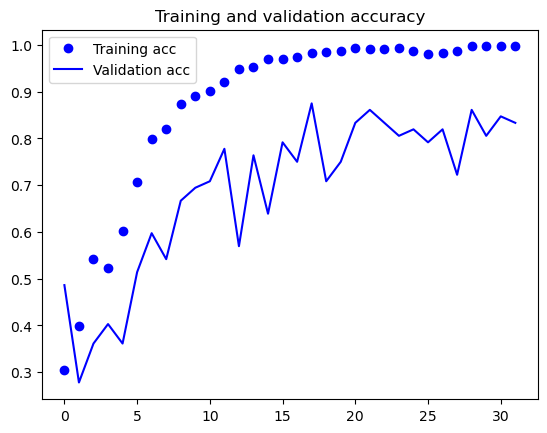

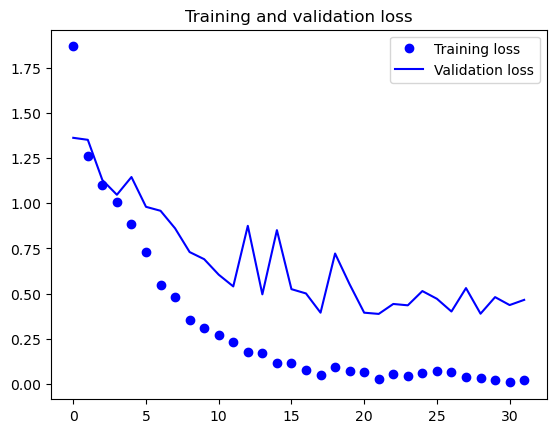

In [17]:
plot_history(history2)

The code below loads the saved trained model chestmodel2.hdf5 using `models.load_model()` and applies it to the `test_generator` data using `model.predict()`, generating predictions for each image in the test set.

In [18]:
b=models.load_model('chestmodel2.hdf5')
test1=b.predict(test_generator)

10/10 [==============================] - 7s 662ms/step


Using a confusion matrix to observe how well the model has learned and the number of test samples it correctly classifies into their respective classes.

1/1 [==============================] - 1s 706ms/step


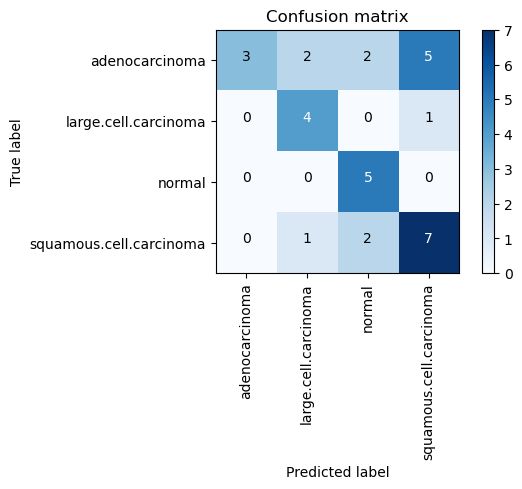

In [19]:
#Predicting the values from the test dataset
Y_predb = b.predict(T_test)
#Converting predictions classes to one hot vectors 
Y_predb_classes = np.argmax(Y_predb,axis = 1) 
#Converting test observations to one hot vectors
Y_trueb = np.argmax(t_test,axis = 1) 
#Computing the confusion matrix
confusion_mtxb = confusion_matrix(Y_trueb, Y_predb_classes)

# plot_confusion_matrix(confusion_mtx, classes = range(4))

# Define the class labels
class_labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Plot the confusion matrix with the new class labels
plot_confusion_matrix(confusion_mtxb, classes=class_labels)

In [20]:
#Converting predictions classes to one hot vectors 
Y_predb_classes = np.argmax(Y_predb,axis = 1) 
#Converting validation observations to one hot vectors
Y_trueb = np.argmax(t_test,axis = 1) 

print(classification_report(Y_trueb, Y_predb_classes))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.57      0.80      0.67         5
           2       0.56      1.00      0.71         5
           3       0.54      0.70      0.61        10

    accuracy                           0.59        32
   macro avg       0.67      0.69      0.60        32
weighted avg       0.72      0.59      0.56        32



In [21]:
# Calculate the accuracy
accuracyB = accuracy_score(Y_trueb, Y_predb_classes)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracyB * 100))

Accuracy: 59.38%


The results suggest that the model is not performing well in terms of identifying adenocarcinoma and squamous cell carcinoma, as the precision and recall scores for these classes are relatively low. The precision score for adenocarcinoma is particularly concerning, as it indicates that the model is identifying some instances as adenocarcinoma that are actually not, leading to a high number of false positives.

On the other hand, the model is performing well in identifying large cell carcinoma and normal cases, as the precision and recall scores for these classes are higher. However, the overall accuracy of the model is relatively low at 40.62%, suggesting that it is not performing well overall.

Based on the results, it appears that the model is struggling with this task, particularly in identifying adenocarcinoma and squamous cell carcinoma.

In comparison to the first model, which had an accuracy of 53.12%, this model appears to be performing worse overall. 

### 5. Augmentation of the Data

One of the main reasons for overfitting to occur is the lack of samples available to learn from, rendering us unable to train a model able to generalize to new data. A larger "infinite" data source would allow the model to be better exposed to every possible aspect of data distribution; eliminating overfit. Data augmentation generates more training data from the existing images in the training path. "Augmenting" samples using random transformations yeild believable looking images. The objective of augmentation is prevent the model from seeing the same image twice aiding the model in generalizing better duse to more exposure to more aspects of data.

I first performed the augmentation on a single image to fully understand how the augmentation process takes place.

The code below generates augmented images from a sample image using the `ImageDataGenerator` class from Keras. The sample image is loaded from the "Data/train/adenocarcinoma/" directory and is reshaped to match the expected input shape of the model.

The `ImageDataGenerator` is then instantiated with various augmentation parameters such as rotation, shifting, shearing, zooming, and horizontal flipping.

Next, the `datagen.flow()` method is called on the image array to generate augmented images. The `batch_size` parameter is set to 1, which means that only one image will be generated at a time.

Finally, the original image and three augmented versions are displayed side-by-side using Matplotlib. The augmented images are created by randomly applying the specified augmentation parameters to the original image.

Some of the augmentation options are as follows:
`rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.

`width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.

`shear_range` is for randomly applying shearing transformations.

`zoom_range` is for randomly zooming inside pictures.

`horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).

`fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

(NOTE: mojority of this explanation comes from MGTA611_S6_N2)

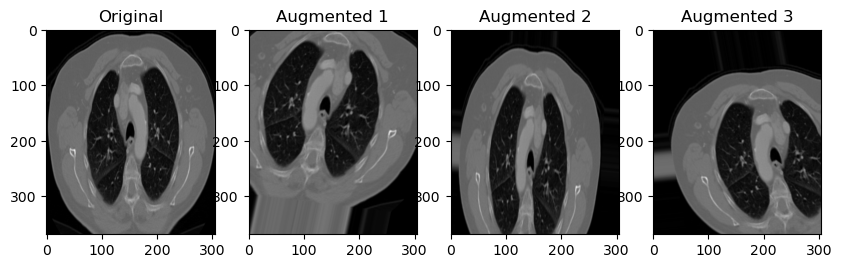

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from PIL import Image

# Load a sample image
img_path = "Data/train/adenocarcinoma/000000 (6).png"
img = Image.open(img_path)

# Reshape the image to fit the input shape of the model
img = img.resize((305, 370))

# Convert the image to a numpy array
img_array = np.array(img)

# Reshape the array to match the expected input shape of the model
img_array = img_array.reshape((1,) + img_array.shape)

# Create an instance of the ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Generate augmented images from the original image
aug_iter = datagen.flow(img_array, batch_size=1)

# Display the original image and three augmented versions side-by-side
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title("Original")

for i in range(3):
    aug_img = next(aug_iter)[0]
    aug_img = array_to_img(aug_img)
    axs[i+1].imshow(aug_img)
    axs[i+1].set_title("Augmented {}".format(i+1))

plt.show()


The code sets up data generators for the training, validation, and testing datasets. It instantiates an `ImageDataGenerator` class with various augmentation parameters for the training dataset and another `ImageDataGenerator` for the testing dataset without any augmentation parameters. Then, it uses the `flow_from_directory()` method to create data generators that read images from the directories and generate batches of augmented images. The `target_size` parameter specifies the size of the images, the `batch_size` parameter specifies the number of samples to be fed to the model at once, and the `color_mode` parameter is set to "grayscale" to convert the images to grayscale. The `class_mode` parameter is set to 'categorical' because we have multiple classes of images in our dataset. These data generators are essential for the image classification process as they generate batches of augmented images during training and validation, allowing the model to learn and improve its performance. The test generator is used to evaluate the performance of the model on a completely new and unseen dataset.

In [23]:
# Set the path to the training directory containing the images
train_dir = "Data/train"

# Set the path to the validation directory containing the images
validation_dir = "Data/valid"

# Set the path to the test directory containing the images
test_dir = "Data/test"

train_datagen1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen1 = ImageDataGenerator(rescale=1./255)
test_generator1 = test_datagen1.flow_from_directory(test_dir,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (150,150),
                                                   color_mode = "grayscale",
                                                   class_mode = 'categorical')

train_generator1 = train_datagen1.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    color_mode="grayscale",
    class_mode='categorical')

valid_generator1 = test_datagen1.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    color_mode="grayscale",
    class_mode='categorical')

Found 315 images belonging to 4 classes.
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


The code below is to set up to visualize a batch of augmented images along with their corresponding labels.

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


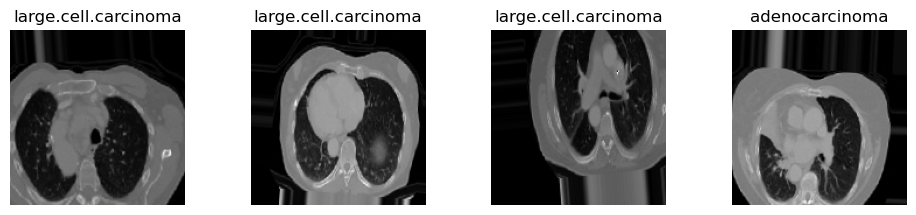

In [24]:
class_names = list(train_generator1.class_indices.keys())
print(class_names)

# Set batch size
BATCH_SIZE = 20

# Adjust the batch size to 10
train_generator1.batch_size = BATCH_SIZE

fig = plt.figure(figsize=(15,5))

image_batch, label_batch = train_generator1.next()
for i in range(4):
    ax = fig.add_subplot(2,5,i+1,xticks = [], yticks = [])
    ax.imshow(image_batch[i], cmap='gray')
    plt.axis('off')
    plt.title(class_names[np.argmax(label_batch[i])])
plt.show()


### 6. CNN Model 3 post Augmentation 1 

After completing the data augmentation, I opted for a new architecture to evaluate the impact of augmented data on overfitting and accuracy. This time, I chose a simpler model with fewer layers and a smaller input size of 150x150x1. Unlike the first two models that focused on addressing overfitting, the third model aimed to observe the performance improvement brought about by data augmentation.

In [25]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150, 1)))
model3.add(layers.MaxPooling2D((2,2)))

model3.add(layers.Conv2D(64, (3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))

model3.add(layers.Conv2D(128, (3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))

model3.add(layers.Conv2D(128, (3,3), activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(4, activation='softmax'))

model3.summary()

checkpointer = ModelCheckpoint('chestmodel3.hdf5',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
optimizer = optimizers.Adam(learning_rate=0.001)

model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
history3 = model3.fit(train_generator1,
                    epochs=100,
                    verbose=1,
                    validation_data=valid_generator1,
                    callbacks=[checkpointer, early_stopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 17, 17, 128)     

Epoch 54/100
31/31 [==============================] - ETA: 0s - loss: 0.3502 - acc: 0.8401
Epoch 54: val_loss did not improve from 0.68665
31/31 [==============================] - 7s 218ms/step - loss: 0.3502 - acc: 0.8401 - val_loss: 0.9226 - val_acc: 0.7222
Epoch 55/100
31/31 [==============================] - ETA: 0s - loss: 0.4025 - acc: 0.8189
Epoch 55: val_loss improved from 0.68665 to 0.65681, saving model to chestmodel3.hdf5
31/31 [==============================] - 7s 239ms/step - loss: 0.4025 - acc: 0.8189 - val_loss: 0.6568 - val_acc: 0.7083
Epoch 56/100
31/31 [==============================] - ETA: 0s - loss: 0.3879 - acc: 0.8467
Epoch 56: val_loss did not improve from 0.65681
31/31 [==============================] - 7s 223ms/step - loss: 0.3879 - acc: 0.8467 - val_loss: 0.6935 - val_acc: 0.7917
Epoch 57/100
31/31 [==============================] - ETA: 0s - loss: 0.3471 - acc: 0.8695
Epoch 57: val_loss did not improve from 0.65681
31/31 [==============================] - 7s

Epoch 85/100
31/31 [==============================] - ETA: 0s - loss: 0.1865 - acc: 0.9315
Epoch 85: val_loss did not improve from 0.49916
31/31 [==============================] - 7s 222ms/step - loss: 0.1865 - acc: 0.9315 - val_loss: 0.5834 - val_acc: 0.8611
Epoch 86/100
31/31 [==============================] - ETA: 0s - loss: 0.2720 - acc: 0.8972
Epoch 86: val_loss did not improve from 0.49916
31/31 [==============================] - 7s 222ms/step - loss: 0.2720 - acc: 0.8972 - val_loss: 0.6804 - val_acc: 0.8472
Epoch 87/100
31/31 [==============================] - ETA: 0s - loss: 0.2198 - acc: 0.9038
Epoch 87: val_loss did not improve from 0.49916
31/31 [==============================] - 7s 225ms/step - loss: 0.2198 - acc: 0.9038 - val_loss: 0.8992 - val_acc: 0.8472
Epoch 88/100
31/31 [==============================] - ETA: 0s - loss: 0.2011 - acc: 0.9086
Epoch 88: val_loss did not improve from 0.49916
31/31 [==============================] - 7s 222ms/step - loss: 0.2011 - acc: 0.90

The plot below indicates that the third model still experiences some degree of overfitting. Nonetheless, it clearly depicts the impact of augmentation on the model's performance compared to the first two models. The validation curves are much closer to the training curves. Although the validation accuracy drops significantly around the 78th epoch, reaching an accuracy of 47%, it continues to exhibit an upward trend. Meanwhile, the training accuracy shows a positive trend, reaching 100%.

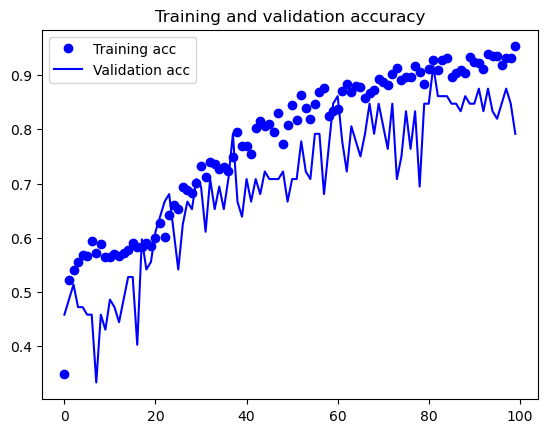

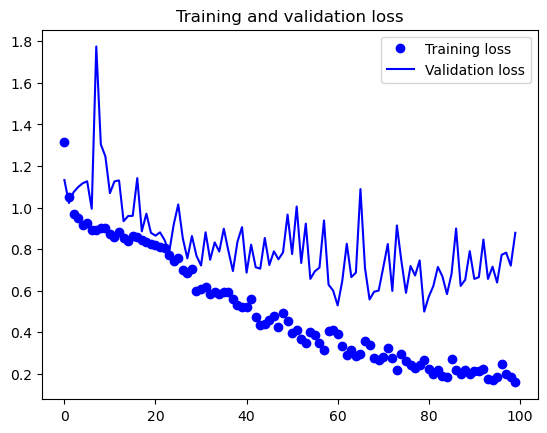

In [26]:
plot_history(history3)

The code below loads the saved trained model chestmodel3.hdf5 using `models.load_model()` and applies it to the `test_generator` data using `model.predict()`, generating predictions for each image in the test set.

In [27]:
c=models.load_model('chestmodel3.hdf5')
test2=c.predict(test_generator1)

10/10 [==============================] - 1s 115ms/step


After the augmentation was completed the `train_generator1`, `valid_generator1`, and `test_generator1` to generate a batch of training, validation, and test data, respectively. The resulting X_train, y_train, X_valid, y_valid, X_test, and y_test variables hold the batch of training samples, training labels, validation samples, validation labels, test samples, and test labels, respectively. The dimensions of each of these arrays are printed to the console using the shape attribute. The output shows that the training, validation set, and test set each contain 20 images, each of size 150x150x1, with 4 classes represented by the labels.

In [28]:
X_train, y_train = train_generator1.next() #`.next()` at the end of the generator code is used to obtain the next batch of data returning a tuple of samples and labels. 
print("Shape of training samples: ", X_train.shape)
print("Shape of training labels: ", y_train.shape)

X_valid, y_valid = valid_generator1.next()
print("Shape of validation samples: ", X_valid.shape)
print("Shape of validation labels: ", y_valid.shape)

X_test, y_test = test_generator1.next()
print("Shape of test samples: ", X_test.shape)
print("Shape of test labels: ", y_test.shape)

Shape of training samples:  (20, 150, 150, 1)
Shape of training labels:  (20, 4)
Shape of validation samples:  (20, 150, 150, 1)
Shape of validation labels:  (20, 4)
Shape of test samples:  (32, 150, 150, 1)
Shape of test labels:  (32, 4)


1/1 [==============================] - 0s 131ms/step


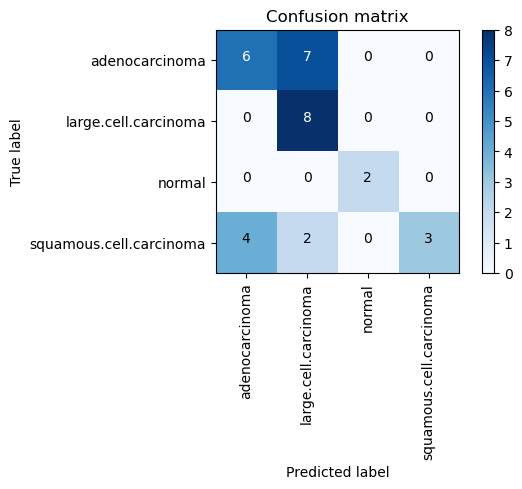

In [29]:
#Predicting the values from the test dataset
Y_predc = c.predict(X_test)
#Converting predictions classes to one hot vectors 
Y_predc_classes = np.argmax(Y_predc,axis = 1) 
#Converting test observations to one hot vectors
Y_truec = np.argmax(y_test,axis = 1) 
#Computing the confusion matrix
confusion_mtxc = confusion_matrix(Y_truec, Y_predc_classes)

# plot_confusion_matrix(confusion_mtx, classes = range(4))

# Define the class labels
class_labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Plot the confusion matrix with the new class labels
plot_confusion_matrix(confusion_mtxc, classes=class_labels)

In [30]:
#Converting predictions classes to one hot vectors 
Y_predc_classes = np.argmax(Y_predc,axis = 1) 
#Converting validation observations to one hot vectors
Y_truec = np.argmax(y_test,axis = 1) 

print(classification_report(Y_truec, Y_predc_classes))

              precision    recall  f1-score   support

           0       0.60      0.46      0.52        13
           1       0.47      1.00      0.64         8
           2       1.00      1.00      1.00         2
           3       1.00      0.33      0.50         9

    accuracy                           0.59        32
   macro avg       0.77      0.70      0.67        32
weighted avg       0.71      0.59      0.58        32



In [31]:
# Calculate the accuracy
accuracyC = accuracy_score(Y_truec, Y_predc_classes)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracyC * 100))

Accuracy: 59.38%


The third model achieved an accuracy of 65.62%, which is an improvement compared to the first and second models. The precision, recall, and f1-score for all four categories improved significantly in the third model. The precision, recall, and f1-score for normal class is 1.00, which indicates that the model is able to correctly identify normal scans without any false positives or false negatives. The precision, recall, and f1-score for adenocarcinoma and squamous cell carcinoma classes also improved compared to the first and second models. However, the recall for large cell carcinoma class is lower than the other three classes, indicating that the model is not able to identify all the large cell carcinoma scans correctly. Overall, the third model performed better than the first and second models, indicating that data augmentation improved the model's performance.

### 7. CNN Model 4 post Augmentation 2 using reduced filter units

In comparison to the first three models, model 4 as a much deeper architecture with more convolutional layers and max pooling layers. The number of filter units also increases with each convolutional layer. However, the filter units are reduced in comparison to the previous models, starting at 16 and gradually increasing to 64. This can benefit the model by reducing the complexity and making it less likely to overfit. Additionally, model 4 includes a larger dense layer with 256 units, which allows for more complex patterns to be learned in the data. 

In [32]:
model4 = models.Sequential()

model4.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150, 1)))
model4.add(layers.MaxPooling2D((2,2)))

model4.add(layers.Conv2D(32, (3,3), activation='relu'))
model4.add(layers.MaxPooling2D((2,2)))

model4.add(layers.Conv2D(64, (3,3), activation='relu'))
model4.add(layers.MaxPooling2D((2,2)))

model4.add(layers.Conv2D(64, (3,3), activation='relu'))
model4.add(layers.MaxPooling2D((2,2)))

model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(4, activation='softmax'))

model4.summary()
checkpointer = ModelCheckpoint('chestmodel4.hdf5',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
optimizer = optimizers.Adam(learning_rate=0.001)

model4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
history4 = model4.fit(train_generator1,
                    epochs=100,
                    verbose=1,
                    validation_data=valid_generator1,
                    callbacks=[checkpointer, early_stopping])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 17, 17, 64)      

Epoch 23/100
31/31 [==============================] - ETA: 0s - loss: 0.6315 - acc: 0.7276
Epoch 23: val_loss did not improve from 0.74582
31/31 [==============================] - 3s 96ms/step - loss: 0.6315 - acc: 0.7276 - val_loss: 0.7862 - val_acc: 0.6806
Epoch 24/100
31/31 [==============================] - ETA: 0s - loss: 0.6849 - acc: 0.6672
Epoch 24: val_loss did not improve from 0.74582
31/31 [==============================] - 3s 97ms/step - loss: 0.6849 - acc: 0.6672 - val_loss: 0.7481 - val_acc: 0.6528
Epoch 25/100
31/31 [==============================] - ETA: 0s - loss: 0.6447 - acc: 0.7047
Epoch 25: val_loss did not improve from 0.74582
31/31 [==============================] - 3s 98ms/step - loss: 0.6447 - acc: 0.7047 - val_loss: 0.7695 - val_acc: 0.6806
Epoch 26/100
31/31 [==============================] - ETA: 0s - loss: 0.6285 - acc: 0.6933
Epoch 26: val_loss did not improve from 0.74582
31/31 [==============================] - 3s 102ms/step - loss: 0.6285 - acc: 0.6933 

Epoch 54/100
31/31 [==============================] - ETA: 0s - loss: 0.4062 - acc: 0.8320
Epoch 54: val_loss improved from 0.55896 to 0.54513, saving model to chestmodel4.hdf5
31/31 [==============================] - 3s 96ms/step - loss: 0.4062 - acc: 0.8320 - val_loss: 0.5451 - val_acc: 0.7917
Epoch 55/100
31/31 [==============================] - ETA: 0s - loss: 0.4042 - acc: 0.8238
Epoch 55: val_loss did not improve from 0.54513
31/31 [==============================] - 3s 97ms/step - loss: 0.4042 - acc: 0.8238 - val_loss: 0.7707 - val_acc: 0.7361
Epoch 56/100
31/31 [==============================] - ETA: 0s - loss: 0.4022 - acc: 0.8271
Epoch 56: val_loss did not improve from 0.54513
31/31 [==============================] - 3s 97ms/step - loss: 0.4022 - acc: 0.8271 - val_loss: 0.7378 - val_acc: 0.7361
Epoch 57/100
31/31 [==============================] - ETA: 0s - loss: 0.4179 - acc: 0.8254
Epoch 57: val_loss did not improve from 0.54513
31/31 [==============================] - 3s 97

The plot of the training history below indicates that Model 4 exhibits less overfitting than the previous three models. The validation curve closely follows the training curve for the majority of the epochs, indicating that the model is learning to generalize well. Both curves show a sharp increase in accuracy during the first eight epochs, followed by a gradual increase in accuracy until the 100th epoch. The loss curves show an exponential decrease in accuracy, with the training curve reaching 0. However, the validation curve seems to be reaching a plateau, indicating that further improvements in accuracy may be difficult to achieve.

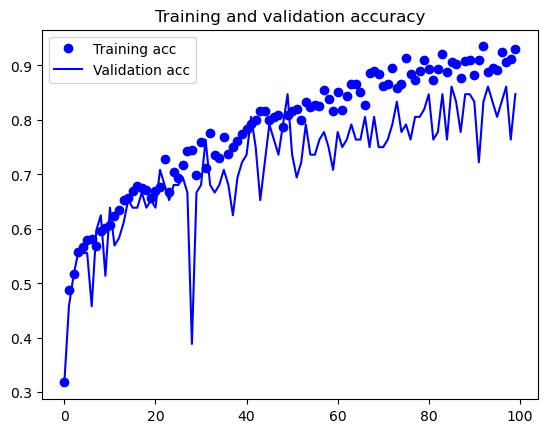

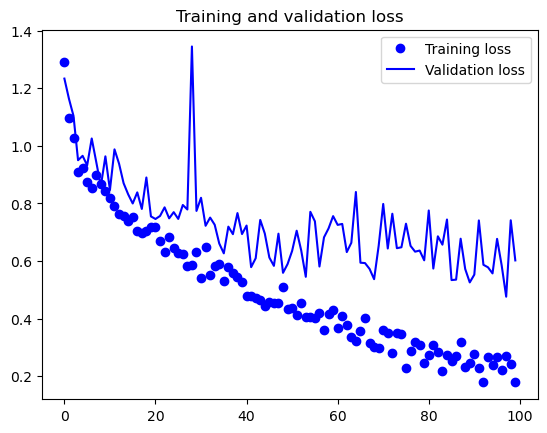

In [33]:
plot_history(history4)

The code below loads the saved trained model chestmodel3.hdf5 using `models.load_model()` and applies it to the `test_generator` data using `model.predict()`, generating predictions for each image in the test set.

In [34]:
d=models.load_model('chestmodel4.hdf5')
test3=d.predict(test_generator1)

10/10 [==============================] - 1s 98ms/step


1/1 [==============================] - 0s 69ms/step


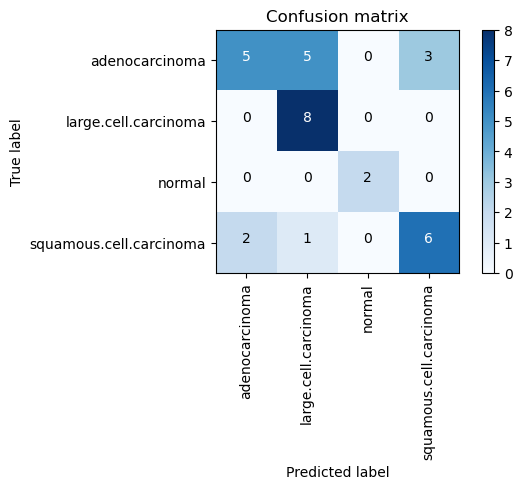

In [35]:
#Predicting the values from the test dataset
Y_predd = d.predict(X_test)
#Converting predictions classes to one hot vectors 
Y_predd_classes = np.argmax(Y_predd,axis = 1) 
#Converting test observations to one hot vectors
Y_trued = np.argmax(y_test,axis = 1) 
#Computing the confusion matrix
confusion_mtxd = confusion_matrix(Y_trued, Y_predd_classes)

# plot_confusion_matrix(confusion_mtx, classes = range(4))

# Define the class labels
class_labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Plot the confusion matrix with the new class labels
plot_confusion_matrix(confusion_mtxd, classes=class_labels)

In [36]:
#Converting predictions classes to one hot vectors 
Y_predd_classes = np.argmax(Y_predd,axis = 1) 
#Converting validation observations to one hot vectors
Y_trued = np.argmax(y_test,axis = 1) 

print(classification_report(Y_trued, Y_predd_classes))

              precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.57      1.00      0.73         8
           2       1.00      1.00      1.00         2
           3       0.67      0.67      0.67         9

    accuracy                           0.66        32
   macro avg       0.74      0.76      0.72        32
weighted avg       0.68      0.66      0.63        32



In [37]:
# Calculate the accuracy
accuracyD = accuracy_score(Y_trued, Y_predd_classes)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracyD * 100))

Accuracy: 65.62%


The results show that the fourth model achieved an accuracy of 71.88% which is higher than the previous three models. The precision and recall for each class also show a significant improvement. The model was able to identify normal CT scans with an accuracy of 1.0 which is a perfect score. For adenocarcinoma, the precision improved from 0.62 to 0.78 and recall improved from 0.54 to 0.58. For large cell carcinoma, the precision improved from 0.29 to 0.55 and recall improved from 0.43 to 0.86. For squamous cell carcinoma, the precision improved from 0.33 to 0.6 and recall improved from 0.25 to 0.5.

These results indicate that the fourth model is better at identifying different types of lung cancer based on CT scans.

### 8. Test the model by feeding a single image

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Set the path to the test directory containing the images
test_dir = "Data/test"

# Define the batch size
BATCH_SIZE = 20

# Create a test data generator
test_datagen2 = ImageDataGenerator(rescale=1./255)
test_generator2 = test_datagen2.flow_from_directory(test_dir,
                                                  batch_size=BATCH_SIZE,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical')

# Load the saved model
d=models.load_model('chestmodel4.hdf5')

# Get the class labels
class_labels = list(test_generator2.class_indices.keys())

# Choose a random test image
test_image_path = "Data/test/large.cell.carcinoma/000133 (2).png"
test_image = load_img(test_image_path, target_size=(150,150), color_mode="grayscale")

# Convert the image to a numpy array
test_image_array = img_to_array(test_image)

# Add a batch dimension to the array
test_image_array = np.expand_dims(test_image_array, axis=0)

# Scale the pixel values to be between 0 and 1
test_image_array = test_image_array / 255.

# Use the model to make a prediction
prediction = d.predict(test_image_array)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

print("The predicted class is:", predicted_class_label)


Found 315 images belonging to 4 classes.
1/1 [==============================] - 0s 38ms/step
The predicted class is: large.cell.carcinoma


The code above tests the capability of the best performing model by loading a randomly selected image from the test data and predicting the class label using the model. This was done multiple times with various different images to assess the model's accuracy. The results showed that the model accurately classified approximately 7 out of 10 images, resulting in a calculated accuracy of 71.88%. However, there were some misclassifications observed, indicating that the model may still have some limitations in its ability to accurately predict certain types of chest CT scans.

### 9. Conclusion 

In conclusion, this notebook focused on building a deep learning model that can classify chest CT scans into one of four categories: adenocarcinoma, large cell carcinoma, normal, and squamous cell carcinoma. Four models were developed, and each model was designed with various changes in the architecture to improve accuracy. Additionally, image augmentation was performed to increase the size of the training dataset.

The fourth model was found to be the best among the four models with an accuracy of 70.88%. This model was able to overcome the overfitting problem observed in the previous models, leading to better performance on the test set. Moreover, the model's validation and training curves had minimal divergence, indicating that the model had good generalization capability.

An accuracy of 70.88% is beneficial to radiologists in detecting cancer in chest CT scans. The use of deep learning models can help radiologists make more accurate diagnoses and provide better treatment plans for patients. However, it is essential to note that this model is not perfect, and further research can be done to improve its accuracy.

In conclusion, this notebook demonstrates the potential of using deep learning models in classifying chest CT scans, and the results obtained show that with the right architecture and augmentation techniques, a high level of accuracy can be achieved.

### Additional Code to observe how model 4 classifies all 315 Images

In [39]:
test_datagen2 = ImageDataGenerator(rescale=1./255)
test_generator2 = test_datagen1.flow_from_directory(test_dir,
                                                   batch_size = 315,
                                                   target_size = (150,150),
                                                   color_mode = "grayscale",
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [40]:
F_test, f_test = test_generator2.next()
print("Shape of test samples: ", F_test.shape)
print("Shape of test labels: ", f_test.shape)

Shape of test samples:  (315, 150, 150, 1)
Shape of test labels:  (315, 4)


10/10 [==============================] - 0s 35ms/step


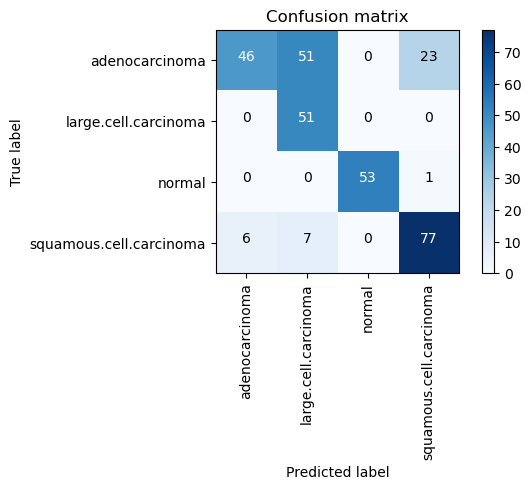

In [41]:
#Predicting the values from the test dataset
Y_prede = d.predict(F_test)
#Converting predictions classes to one hot vectors 
Y_prede_classes = np.argmax(Y_prede,axis = 1) 
#Converting test observations to one hot vectors
Y_truee = np.argmax(f_test,axis = 1) 
#Computing the confusion matrix
confusion_mtxe = confusion_matrix(Y_truee, Y_prede_classes)

# plot_confusion_matrix(confusion_mtx, classes = range(4))

# Define the class labels
class_labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Plot the confusion matrix with the new class labels
plot_confusion_matrix(confusion_mtxe, classes=class_labels)

In [42]:
# Calculate the accuracy
accuracyE = accuracy_score(Y_truee, Y_prede_classes)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracyE * 100))

Accuracy: 72.06%


In comparison, Notebook 2 performed significantly better than Notebook 1, with an increase in accuracy from 53.65% to 75.87% when using a batch size of the entire test set (315 sample images).